# MUAP Decomposition Analysis

In [2]:
from emgdecomp.decomposition import EmgDecomposition
from emgdecomp.parameters import EmgDecompositionParams

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from src.utils import load_config
from src.data.filter import Filter
from src.data.utils import bipolar_conversion, load_data, load_data_deprecated, average_reference

In [3]:
data_dir = "/Users/johnzhou/research/rumi/data/"
expt_name = "John-Zhou_2023-07-13-1428_Open-Loop-Typing-Task"
key_fname = data_dir + expt_name + "/data_streams/key_stream.bin"
emg_fname = data_dir + expt_name + "/data_streams/emg_stream.bin"

key_data = load_data_deprecated(key_fname)
emg_data = load_data_deprecated(emg_fname)

fn = [60, 120, 180, 60, 300, 240]
qs = [10, 5, 2, 4, 2, 2]
fc = (10, 900)
fs = 4000
bp_offset = 2
downsample_factor = 2
Fs = fs // downsample_factor

emg_data = emg_data['emg_stream'][..., 1:65]
emg_filter = Filter(notch_freqs=fn, quality_factors=qs, fc=fc, butterworth_type='bandpass', order=4, sampling_freq=fs)
emg_data = emg_filter.filter_data(emg_data)
emg_data = bipolar_conversion(emg_data, bp_offset)

emg_data = emg_data[::downsample_factor]

This function is used to load data of a deprecated format.
This function is used to load data of a deprecated format.


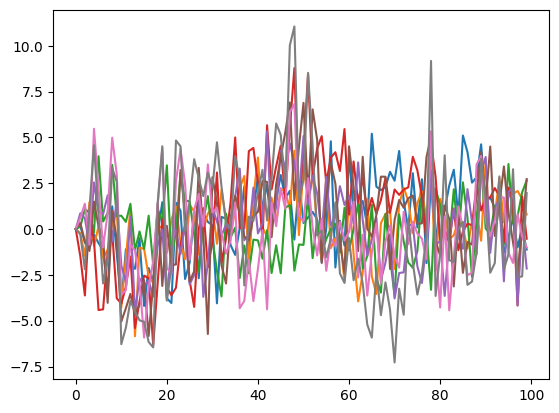

In [4]:
for i in range(0, 8):
    plt.plot(emg_data[:100, i])

Initialize model on first 60s of data

In [5]:
params = EmgDecompositionParams(Fs)
params.regularization_factor=0.5 
params.max_similarity = 0.3
params.source_acceptance_metric = 'sil'
params.sil_threshold = 0.85
params.waveform_duration_ms = 20
print(params.extension_factor)
emgde = EmgDecomposition(params)

start_time = 0
end_time = 60

firings = emgde.decompose(emg_data[start_time * Fs:end_time * Fs, :].T)

16


In [10]:
print(np.array(firings.tolist()).shape)

(372, 4)


In [8]:
print("num sources:", np.unique(np.array([st[0] for st in firings])).size)
print("num_spikes:", len(firings))

num sources: 9
num_spikes: 518


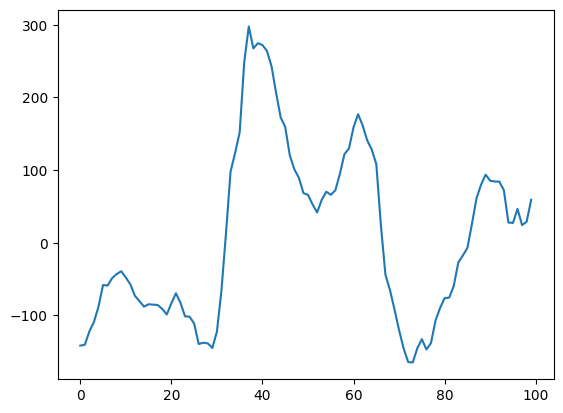

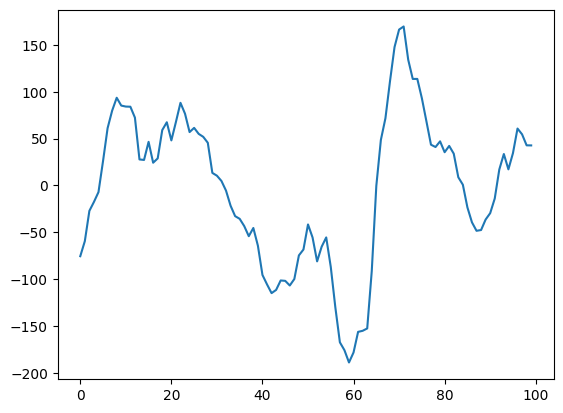

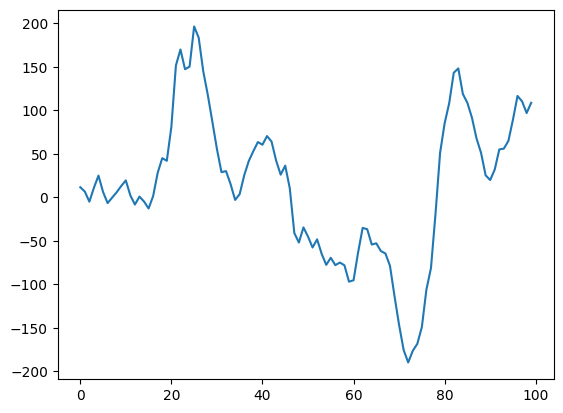

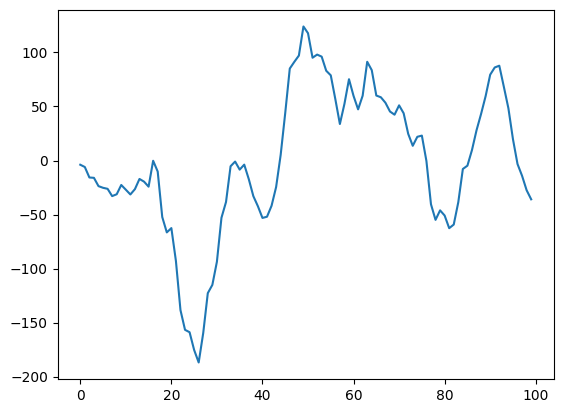

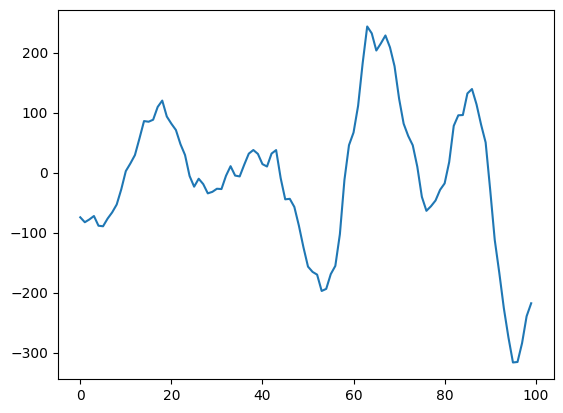

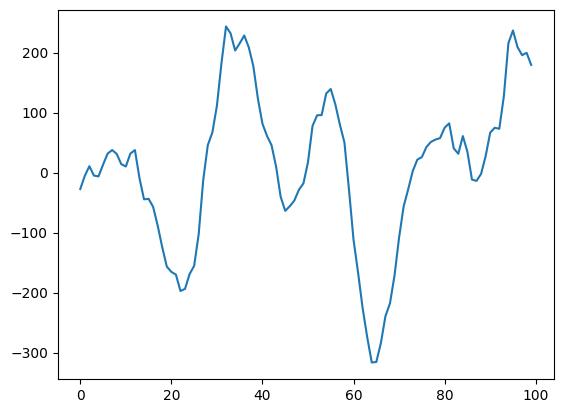

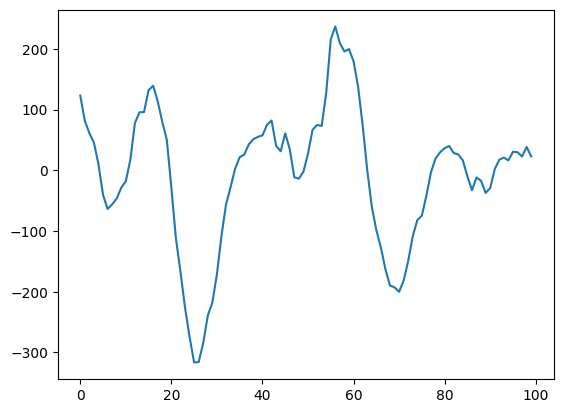

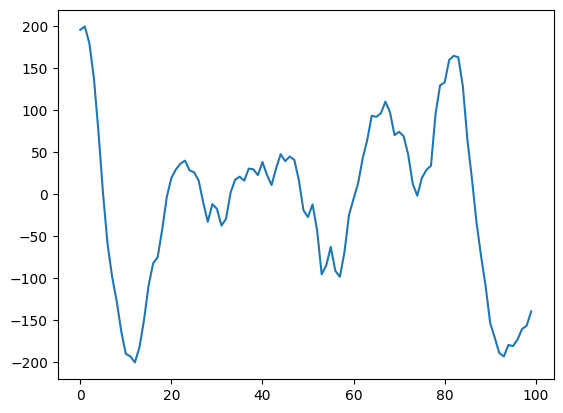

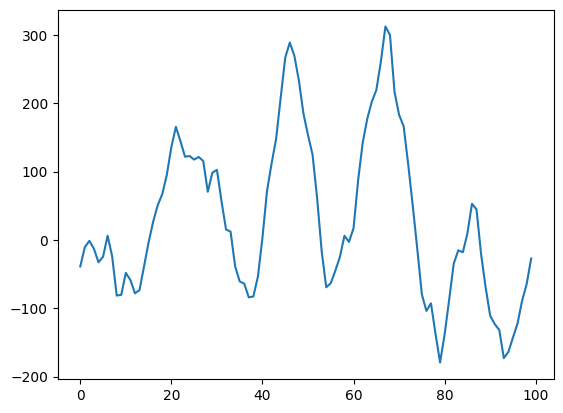

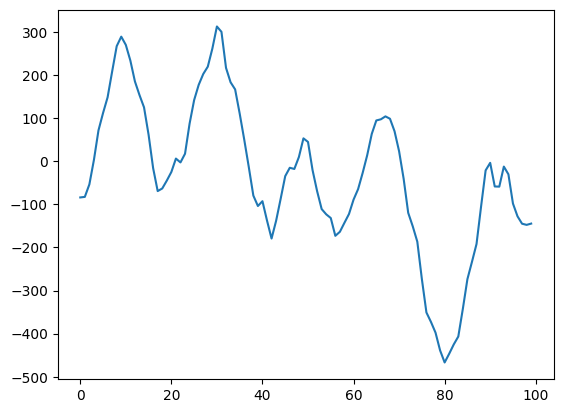

In [11]:
window_size = 0.050 * Fs

for muap in firings[:10]:
    unit_idx, data_idx, seconds, _ = muap
    window = emg_data[int(data_idx-window_size/2):int(data_idx+window_size/2), :]
    selected_chan = np.argmax(np.ptp(window, axis=0))
    plt.figure()
    plt.plot(window[:, selected_chan])
    plt.show()

Transform another set of data

In [26]:
start_time = 60
end_time = 120

firings = emgde.decompose_batch(emg_data[start_time * Fs:end_time * Fs, :].T)

In [16]:
print("num sources:", np.unique(np.array([st[0] for st in firings])).size)
print("num_spikes:", len(firings))

num sources: 9
num_spikes: 353
